In [10]:
#データの取得
# from sklearn import datasets
import pandas as pd
# import weasyprint
# from IPython.core.display import HTML
data=pd.read_csv('./dataset/BostonHousing_r.csv')
# 説明変数


exp_vars = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'LSTAT']
# 目的変数
tar_var = "MEDV"
X = data[exp_vars]
display(X.shape)
X.head()
y = data[tar_var]
from sklearn.ensemble import RandomForestRegressor
# from sklearn.datasets import load_boston
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
# from sklearn.datasets import load_boston
#ボストンの住宅価格予想データを使う
# boston = load_boston()
# X = pd.DataFrame(boston.data, columns=boston.feature_names)
# y = boston.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)
model=RandomForestRegressor()
model.fit(X_train,y_train)
#おそらくデフォルトでははいっていないので、インストールしましょう
import eli5
from eli5.sklearn import PermutationImportance
perm = PermutationImportance(model, random_state=1).fit(X_test,y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())


import eli5
from eli5.sklearn import PermutationImportance
PFI = PermutationImportance(lgb, random_state=1).fit(X_train, y_train)
eli5.show_weights(PFI, feature_names = X_train.columns.tolist())
# # 他の必要なライブラリのインポートなど
# # eli5.show_weightsで表示されるテーブルの背景色を変更するCSS
# css = """
# <style>
#     table {
#         width: 100%; /* テーブルを横幅100%に */
#         border-collapse: collapse; /* セルのボーダーを重ねる */
#         margin-top: 10px; /* 上部のマージンを追加 */
#     }
#     th, td {
#         padding: 8px; /* セル内のパディングを設定 */
#         text-align: left; /* セル内のテキストを左寄せに */
#     }
#     th {
#         background-color: #f2f2f2; /* ヘッダーの背景色を設定 */
#     }
#     td {
#         background-color: #e6f7ff; /* セルの背景色を設定 */
#     }
# </style>
# """
# # CSSを表示
# from IPython.core.display import HTML
# HTML(css)
# # eli5.show_weightsを実行
# eli5.show_weights(perm, feature_names = X_test.columns.tolist())

(506, 12)

# 【ML】Permutation アヤメデータ
 


https://blog.amedama.jp/entry/permutation-importance#google_vignette

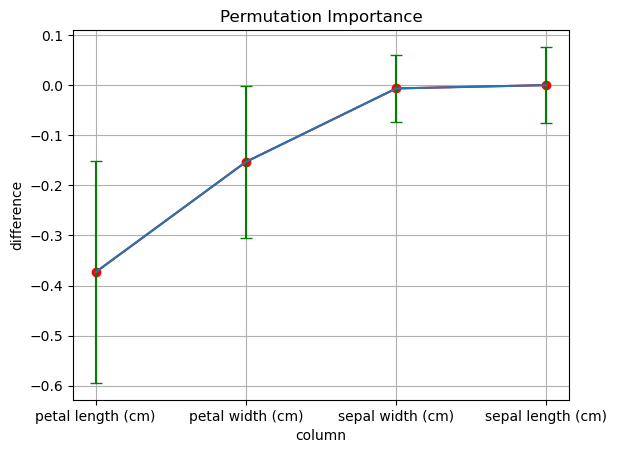

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

from collections import defaultdict

import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from matplotlib import pyplot as plt


def permuted(df):
    """特定のカラムをシャッフルしたデータフレームを返す"""
    for column_name in df.columns:
        permuted_df = df.copy()
        permuted_df[column_name] = np.random.permutation(permuted_df[column_name])
        yield column_name, permuted_df


def pimp(clf, X, y, cv=None, eval_func=accuracy_score):
    """PIMP (Permutation IMPortance) を計算する"""
    base_scores = []
    permuted_scores = defaultdict(list)

    if cv is None:
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for train_index, test_index in cv.split(X, y):
        # 学習用データと検証用データに分割する
        X_train, y_train = X.iloc[train_index], y.iloc[train_index]
        X_test, y_test = X.iloc[test_index], y.iloc[test_index]

        # 学習用データでモデルを学習する
        clf.fit(X_train, y_train)

        # まずは何もシャッフルしていないときのスコアを計算する
        y_pred_base = clf.predict(X_test)
        base_score = eval_func(y_test, y_pred_base)
        base_scores.append(base_score)

        # 特定のカラムをシャッフルした状態で推論したときのスコアを計算する
        permuted_X_test_gen = permuted(X_test)
        for column_name, permuted_X_test in permuted_X_test_gen:
            y_pred_permuted = clf.predict(permuted_X_test)
            permuted_score = eval_func(y_test, y_pred_permuted)
            permuted_scores[column_name].append(permuted_score)

    # 基本のスコアとシャッフルしたときのスコアを返す
    np_base_score = np.array(base_scores)
    dict_permuted_score = {name: np.array(scores) for name, scores in permuted_scores.items()}
    return np_base_score, dict_permuted_score


def score_difference_statistics(base, permuted):
    """シャッフルしたときのスコアに関する統計量 (平均・標準偏差) を返す"""
    mean_base_score = base.mean()
    for column_name, scores in permuted.items():
        score_differences = scores - mean_base_score
        yield column_name, score_differences.mean(), score_differences.std()


def main():
    # Iris データセットを読み込む
    dataset = datasets.load_iris()
    X = pd.DataFrame(dataset.data, columns=dataset.feature_names)
    y = pd.Series(dataset.target)

    # 計測に使うモデルを用意する
    clf = RandomForestClassifier(n_estimators=100)

    # Permutation Importance を計測する
    base_score, permuted_scores = pimp(clf, X, y)

    # 計測結果から統計量を計算する
    diff_stats = list(score_difference_statistics(base_score, permuted_scores))

    # カラム名、ベーススコアとの差、95% 信頼区間を取り出す
    sorted_diff_stats = sorted(diff_stats, key=lambda x: x[1])
    column_names = [name for name, _, _ in sorted_diff_stats]
    diff_means = [diff_mean for _, diff_mean, _ in sorted_diff_stats]
    diff_stds_95 = [diff_std * 1.96 for _, _, diff_std in sorted_diff_stats]

    # グラフにプロットする
    plt.plot(column_names, diff_means, marker='o', color='r')
    plt.errorbar(column_names, diff_means, yerr=diff_stds_95, ecolor='g', capsize=4)

    plt.title('Permutation Importance')
    plt.grid()
    plt.xlabel('column')
    plt.ylabel('difference')
    plt.show()
if __name__ == '__main__':
    main()

# 【ML】Permutation Importance



In [15]:
##############################
#データの読み込み
##############################
import pandas as pd
TRAIN = pd.read_csv('titanic\\train.csv')
TRAIN = TRAIN[['Survived', 'Pclass',  'Sex', 'Age', 'SibSp', 'Parch',  'Fare',  'Embarked']]
TRAIN = pd.get_dummies(TRAIN, drop_first=True)
TRAIN = TRAIN.fillna(TRAIN.median())
X_train = TRAIN.iloc[:,1:]
y_train = TRAIN['Survived']
##############################
#モデル作成と予測
##############################
from lightgbm import LGBMClassifier 
lgb = LGBMClassifier()
lgb.fit(X_train,y_train)
##############################
#PFIで評価
##############################
import eli5
from eli5.sklearn import PermutationImportance
PFI = PermutationImportance(lgb, random_state=1).fit(X_train, y_train)
eli5.show_weights(PFI, feature_names = X_train.columns.tolist())

[LightGBM] [Info] Number of positive: 342, number of negative: 549
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000243 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222
[LightGBM] [Info] Number of data points in the train set: 891, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383838 -> initscore=-0.473288
[LightGBM] [Info] Start training from score -0.473288
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [16]:
pd.DataFrame(lgb.feature_importances_, 
             index=X_train.columns.tolist(), 
             columns=['importance']
            ).sort_values('importance',ascending= False)

importance
Fare              1377
Age               1089
Pclass             112
SibSp              110
Embarked_S         108
Sex_male            88
Parch               75
Embarked_Q          40

【ML】permutation importance

# https://qiita.com/kenmatsu4/items/c49059f78c2b6fed0929

In [10]:
from sklearn.inspection import permutation_importance

In [11]:
from sklearn.metrics import mean_squared_error, make_scorer
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred)) 
mse_scorer = make_scorer(rmse)


In [12]:
FOLD_NUM = 5
fold_seed = 71
folds = KFold(n_splits=FOLD_NUM, shuffle=True, random_state=fold_seed)
fold_iter = folds.split(X, y=y)

oof_preds = np.zeros(X.shape[0])
y_preds = np.zeros((FOLD_NUM, X_test.shape[0]))
models = []
importance_list = []
perm_imp_list = []
fold_label = np.zeros(X.shape[0])
for n_fold, (trn_idx, val_idx) in enumerate(fold_iter):
    print(f"========= fold:{n_fold} =========")

    X_train, X_valid = X.iloc[trn_idx], X.iloc[val_idx]
    y_train, y_valid = y[trn_idx], y[val_idx]

    params_fit = {'X': X_train,
                  'y': y_train,
                  'eval_set': (X_valid, y_valid),
                  'early_stopping_rounds': 5,
                  'verbose': False,
                  'eval_metric': 'l2',
                 }
    model = lgb.LGBMRegressor(objective="regression", n_estimators=100, importance_type="gain", random_state=123)
    gbm = model.fit(**params_fit, callbacks=callbacks)
    models += [model]

    fold_label[val_idx] = n_fold
    oof_preds[val_idx] = model.predict(X_valid, model.best_iteration_)

    # Feature importance
    importance_df = pd.DataFrame({"gain":model.feature_importances_}, index=X.columns).sort_values("gain", ascending=False)
    importance_list += [importance_df]
    print("[Importance]")
    display(importance_df)

    # run permutation importance
    result = permutation_importance(model, X_train, y_train, scoring=mse_scorer, n_repeats=10, n_jobs=-1, random_state=71)
    perm_imp_df = pd.DataFrame({"importances_mean":result["importances_mean"], "importances_std":result["importances_std"]}, index=X.columns)
    perm_imp_list += [perm_imp_df]
    print("[Permutation feature Importance]")
    display(perm_imp_df)
    perm_imp_df.sort_values("importances_mean", ascending=False).importances_mean.plot.barh()
    plt.show()


NameError: name 'KFold' is not defined

# 【ML】SHAP

# https://qiita.com/shin_mura/items/cde01198552eda9146b7

In [5]:
from sklearn import datasets
import pandas as pd
data=pd.read_csv('./dataset/BostonHousing_r.csv')
exp_vars = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
tar_var = "MEDV"
X = data[exp_vars]
y = data[tar_var]
model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X, label=y), 100)


In [6]:
# jupyter notebookにコードを表示させるためにjsをロード
shap.initjs()

explainer = shap.TreeExplainer(model=model, feature_dependence='tree_path_dependent', model_output='margin')


model_output = "margin" has been renamed to model_output = "raw"


ValueError: The feature_dependence option has been renamed to feature_perturbation! Please update the option name before calling TreeExplainer. See GitHub issue #882.

# 【ML】SHAP

https://qiita.com/perico_v1/items/fbbb18681ecc362a4f9e

In [9]:
# ライブラリの読み込み
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
# SHAP(SHapley Additive exPlanations)
import shap
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
%matplotlib inline
#データの取得
from sklearn import datasets
import pandas as pd
data=pd.read_csv('./dataset/BostonHousing_r.csv')
# 説明変数
exp_vars = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
# 目的変数
tar_var = "MEDV"
X = data[exp_vars]
display(X.shape)
# X.head()
y = data[tar_var]
display(y.shape)
# y.head()

(506, 13)

(506,)

In [10]:
# 訓練データとテストデータに分ける
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


In [11]:
params = {'n_estimators': 100,
          'max_depth': 5,
          'min_samples_split': 5,
          'learning_rate': 0.01,
          'loss': 'ls'}

xgb = XGBRegressor(**params)

params_search = {'n_estimators': [10, 100, 1000]}
grid = GridSearchCV(xgb, params_search, cv=10, n_jobs=-1, verbose=True)
grid.fit(X_train, y_train)

print('Grid best parameter: ', grid.best_params_)
# Grid best parameter:  {'n_estimators': 1000}

params = {'n_estimators': grid.best_params_['n_estimators'],
          'max_depth': 5,
          'min_samples_split': 5,
          'learning_rate': 0.01,
          'loss': 'ls'}

xgb = XGBRegressor(**params)
xgb.fit(X_train, y_train)

# 一応確認
print(mean_absolute_error(y_train, xgb.predict(X_train)))
print(mean_absolute_error(y_test, xgb.predict(X_test)))
# 0.34361747671655346
# 2.526548767717261


Fitting 10 folds for each of 3 candidates, totalling 30 fits


[16:08:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "loss", "min_samples_split" } are not used.



Grid best parameter:  {'n_estimators': 1000}
0.3029837126112254
2.4114536868898493


In [12]:
# 予測結果
y_pred = xgb.predict(X_train)

# 最初の5レコード分の予測値
print(y_pred[0:5].round(1))
# [14.3 24.3 17.8 22.9 20.4]

# 予測値の平均
y_pred.mean()
# 22.743422

# 訓練データの特徴量
X_train.head()


[14.5 24.7 18.  22.7 20.3]


CRIM    ZN  INDUS  CHAS    NOX     RM    AGE     DIS  RAD  TAX  \
141  1.62864   0.0  21.89     0  0.624  5.019  100.0  1.4394    4  437   
272  0.11460  20.0   6.96     0  0.464  6.538   58.7  3.9175    3  223   
135  0.55778   0.0  21.89     0  0.624  6.335   98.2  2.1107    4  437   
298  0.06466  70.0   2.24     0  0.400  6.345   20.1  7.8278    5  358   
122  0.09299   0.0  25.65     0  0.581  5.961   92.9  2.0869    2  188   

     PTRATIO       B  LSTAT  
141     21.2  396.90  34.41  
272     18.6  394.96   7.73  
135     21.2  394.67  16.96  
298     14.8  368.24   4.97  
122     19.1  378.09  17.93

In [13]:
explainer = shap.TreeExplainer(xgb)

# SHAP値は「shap._explanation.Explanation」で持つか、array型で持つかで出し方が少し変わる
shap_values = explainer(X_train) # shap._explanation.Explanation型の場合
shap_values_ar = explainer.shap_values(X_train) # numpy.ndarray型の場合
print('shap_values: ', type(shap_values))
print('shap_values_ar: ', type(shap_values_ar))
# shap_values:  <class 'shap._explanation.Explanation'>
# shap_values_ar:  <class 'numpy.ndarray'>


[16:08:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


shap_values:  <class 'shap._explanation.Explanation'>
shap_values_ar:  <class 'numpy.ndarray'>


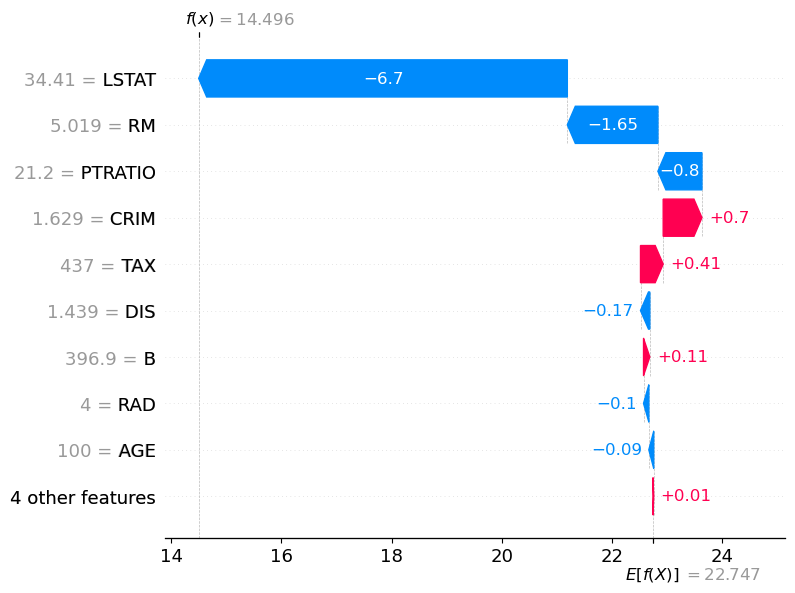

In [14]:
# 訓練データの1レコード目の各特徴量のSHAP値を滝グラフで可視化
shap.plots.waterfall(shap_values[0])


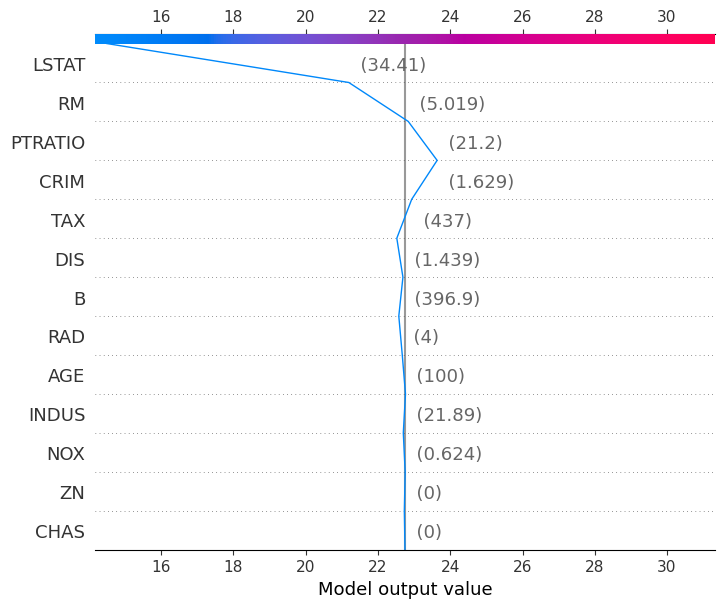

In [15]:
# 訓練データの1レコード目の各特徴量が予測結果に与える影響を可視化
# モデルのbase valueはグラフ中央付近のグレーの線で、グラフ上部の目盛りと折れ線の接点が最終的な予測値になっている
# 各特徴量がbase valueにどの程度作用して最終的な予測値になっているかがわかるようになっている
shap.decision_plot(explainer.expected_value, shap_values_ar[0], X_train.iloc[[0], :])


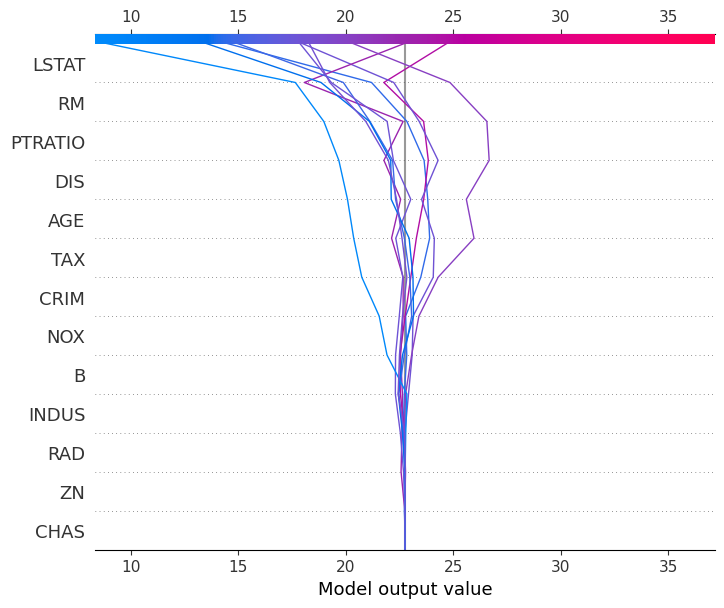

In [16]:
# 訓練データの10レコード分をdesicion_plotで可視化した場合
shap.decision_plot(explainer.expected_value, shap_values_ar[0:10], X_train.iloc[0:10, :])


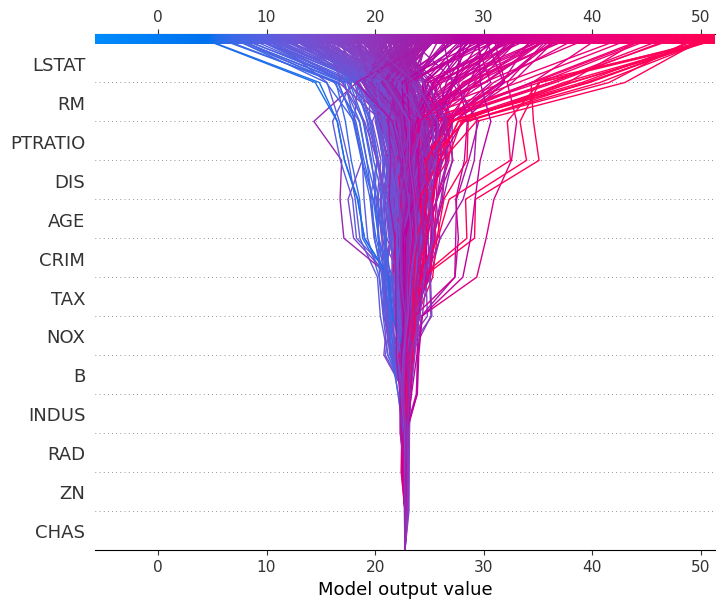

In [17]:
# 訓練データの全てをdesicion_plotで可視化した場合
shap.decision_plot(explainer.expected_value, shap_values_ar, X_train)


In [18]:
# 訓練データの1レコード目の各特徴量のSHAP値を数直線上で可視化
shap.initjs()
shap.plots.force(shap_values[0])
# 以下でも同じ結果になる
# shap.force_plot(explainer.expected_value, shap_values_ar[0], X_train.iloc[0, :])


In [19]:
# 訓練データの初めの3レコードについてSHAP値を可視化
shap.initjs()
num = 3
shap.force_plot(explainer.expected_value, shap_values_ar[0:num], X_train.iloc[0:num, :])


In [20]:
# 訓練データの全レコードについてSHAP値を可視化
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values_ar, X_train)


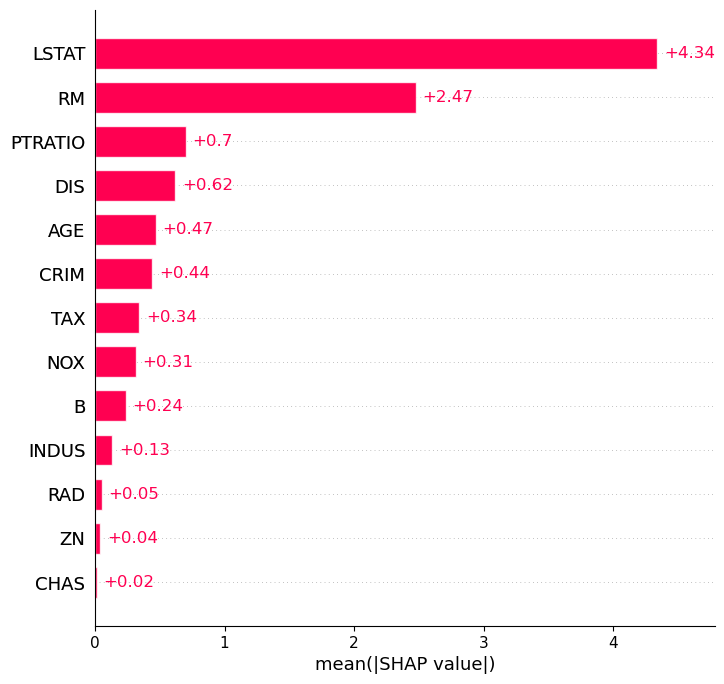

In [21]:
# 各特徴量のSHAP値の絶対値の平均(つまり、各特徴量の予測に対する寄与度)を棒グラフで表示
# 予測に対する寄与度が大きい順にソートされて表示される
shap.plots.bar(shap_values, max_display=20) # max_displayで表示する変数の最大数を指定


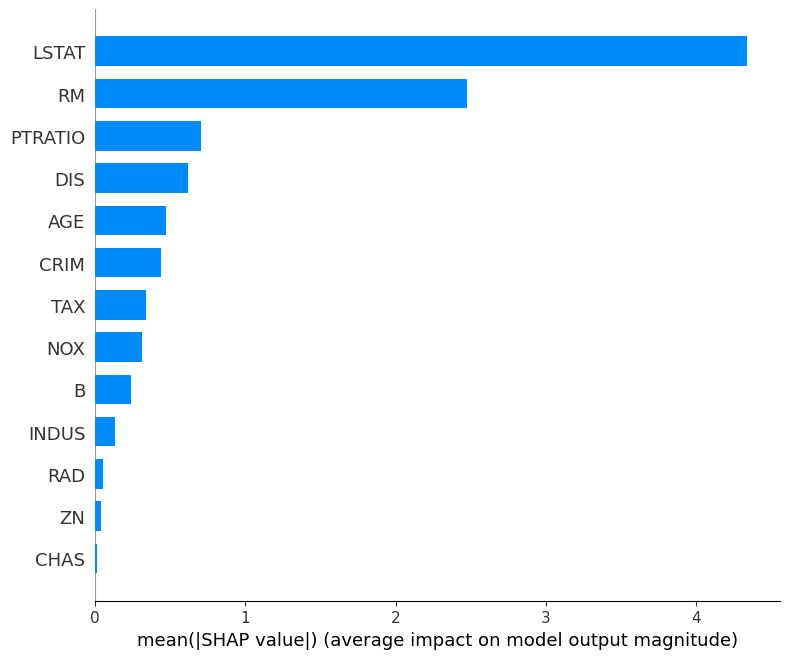

In [22]:
# 少し見た目が異なるが、以下でも同じグラフが作れる
shap.summary_plot(shap_values_ar, X_train, show=True, plot_type='bar', max_display=20) # max_displayで表示する変数の最大数を指定


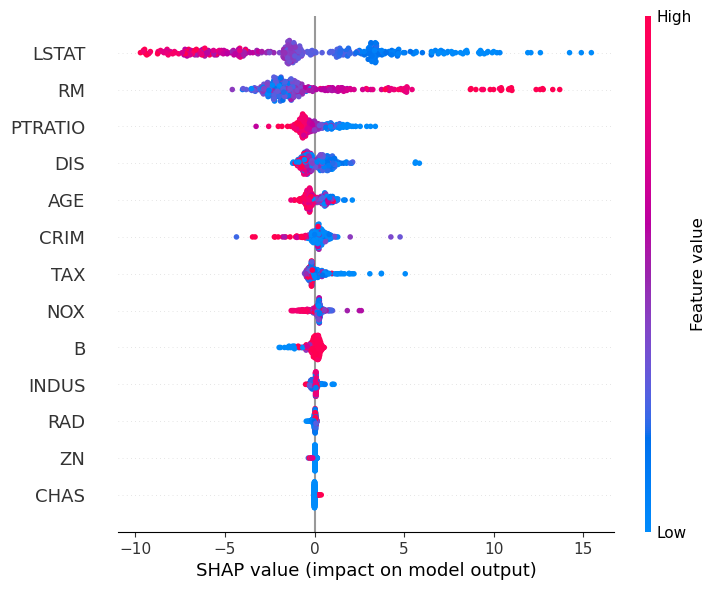

In [23]:
# 全サンプルについて、各特徴量のSHAP値の分布を可視化したもの
# 上記の棒グラフ同様、予測に対する寄与度が大きい順にソートされて表示される
# 色は特徴量の値の大小を表している(赤が大きくて青が小さい)
# LSTATの値が小さいほど予測値(住宅価格)は大きくなることがわかる
shap.plots.beeswarm(shap_values, max_display=20) # max_displayで表示する変数の最大数を指定

# 以下でも同じ結果が得られる
# shap.summary_plot(shap_values_ar, X_train, show=True)


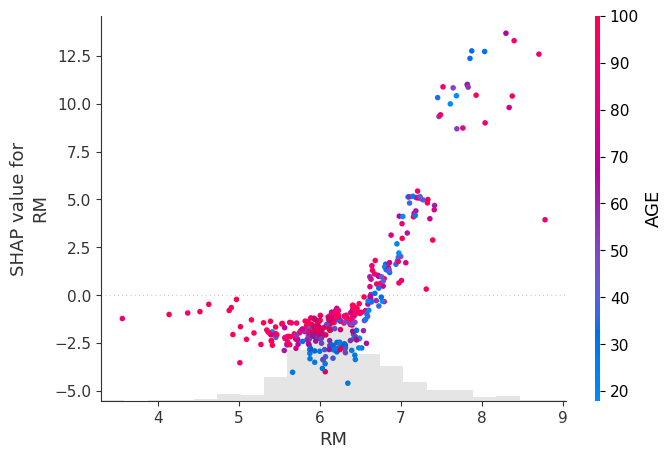

In [24]:
# ある1つの特徴量(今回はRM)について、訓練データ全体でのその特徴量(RM)の値と、対応するSHAP値の散布図を作成
# 横軸が特徴量の値、縦軸が対応するSHAP値
# SHAP値は予測値に対する特徴量の寄与を示すので、この図から、RMが変化したら予測値がどう変化するか読み取れる
# RMが大きいほどSHAP値は大きい、つまり、home priceが大きくなることを示している

# また、このグラフでは選択した特徴量(RM)と他の特徴量との相互作用も確認できるようになっていて
# color引数にshap値の変数を指定すると、自動的に適した変数が選択される
# 今回はRADが選ばれていて、RADの大小によって、同じRMでもSHAP値が異なることが確認できる
shap.plots.scatter(shap_values[:,'RM'], color=shap_values)


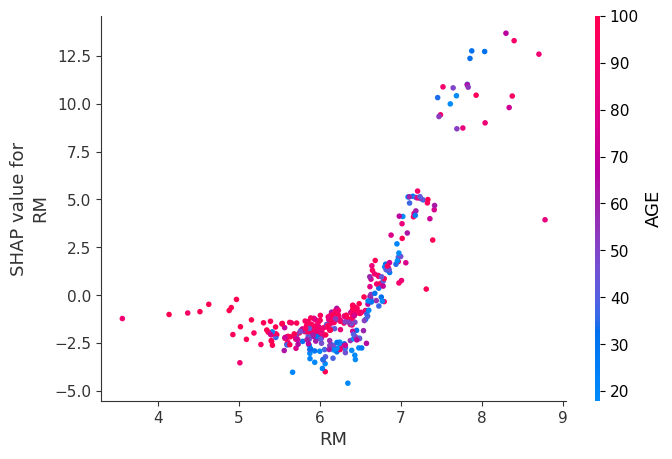

In [25]:
# 以下でも似たグラフが描画できる。ヒストグラムは付いてこない
shap.dependence_plot('RM', shap_values_ar, X_train, show=True)


# 【ML】Ramdom Forest ぼ


https://qiita.com/maskot1977/items/150a12c2fe0daacc6057

In [26]:
# ライブラリの読み込み
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
# SHAP(SHapley Additive exPlanations)
import shap
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
%matplotlib inline
#データの取得
from sklearn import datasets
import pandas as pd
data=pd.read_csv('./dataset/BostonHousing_r.csv')
# 説明変数
exp_vars = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
# 目的変数
tar_var = "MEDV"
X = data[exp_vars]
display(X.shape)
# X.head()
y = data[tar_var]
display(y.shape)
# y.head()

(506, 13)

(506,)

In [27]:

from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(random_state=0)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=0)

In [28]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)


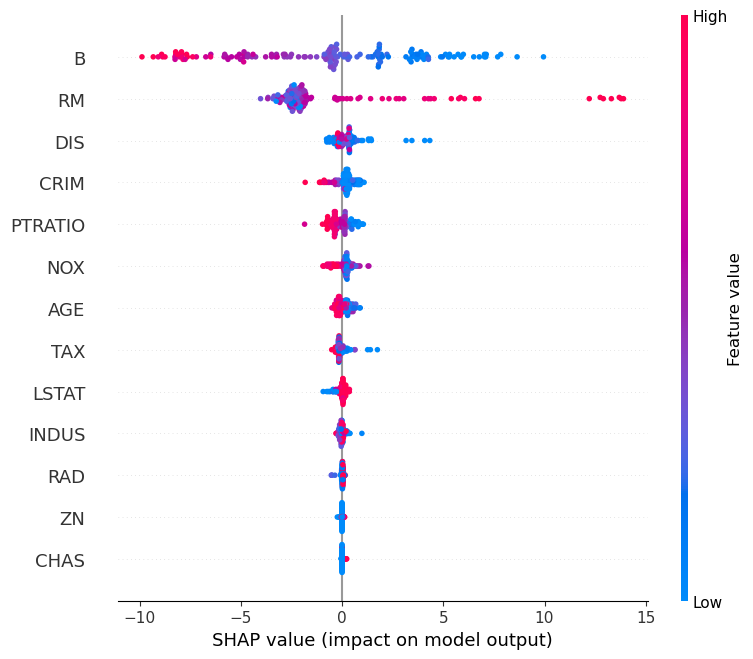

In [31]:
columns =  ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'LSTAT', 'B']
shap.summary_plot(shap_values, X_test, feature_names=columns)

【ML】SHAP

?

In [1]:
#データの取得
from sklearn import datasets
import pandas as pd
data=pd.read_csv('./dataset/BostonHousing_r.csv')
# 説明変数
exp_vars = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
# 目的変数
tar_var = "MEDV"
X = data[exp_vars]
# display(X.shape)
# X.head()
y = data[tar_var]
# display(y.shape)
# y.head()

[15:54:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


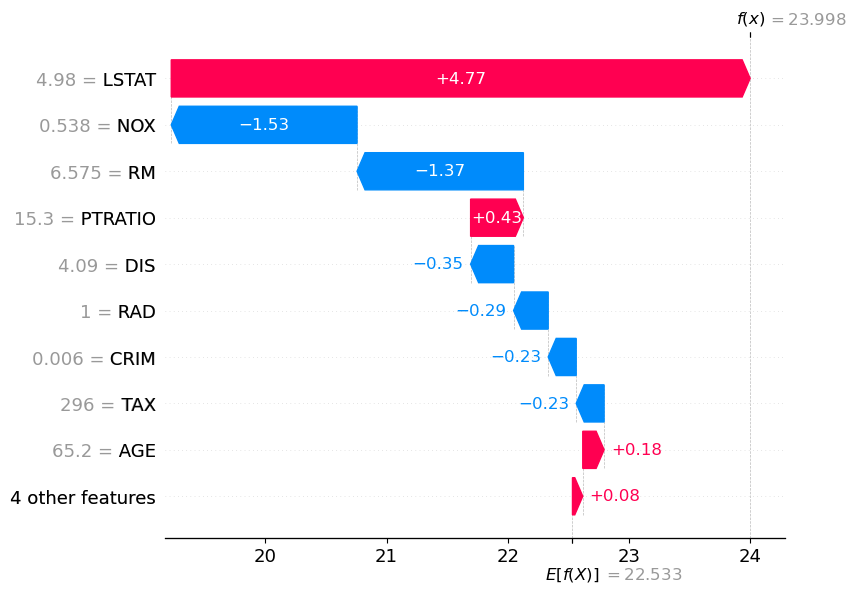

In [2]:
import xgboost
import shap
# train an XGBoost model
# X, y = shap.datasets.boston()
model = xgboost.XGBRegressor().fit(X, y)
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model)
shap_values = explainer(X)
# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

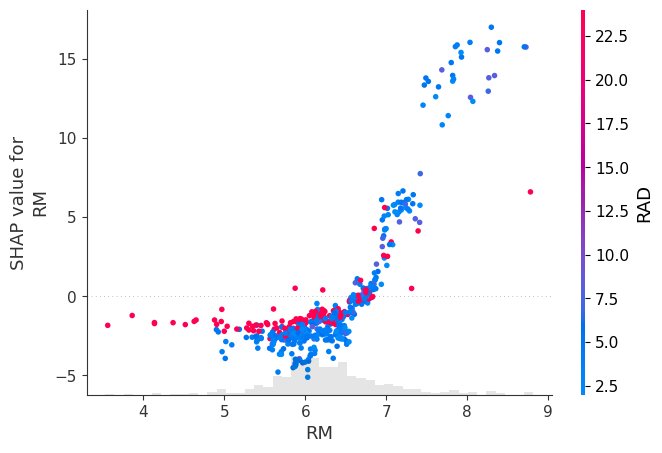

In [3]:
shap.plots.scatter(shap_values[:,"RM"], color=shap_values)

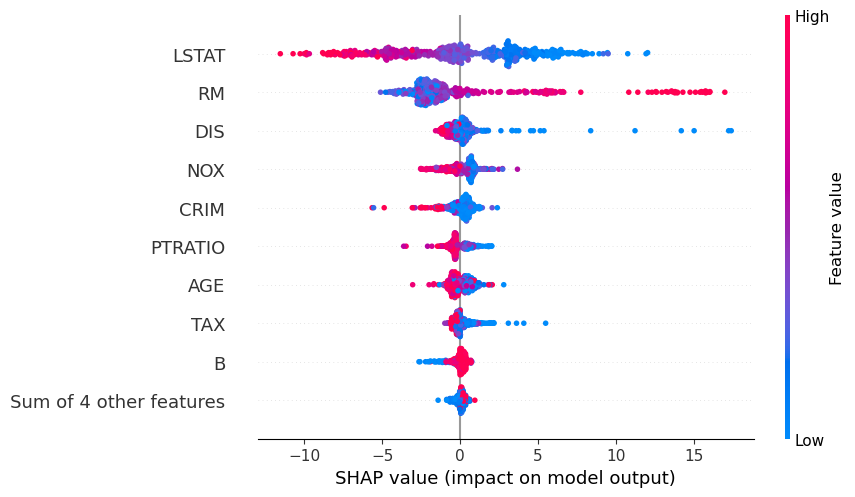

In [4]:
shap.plots.beeswarm(shap_values)

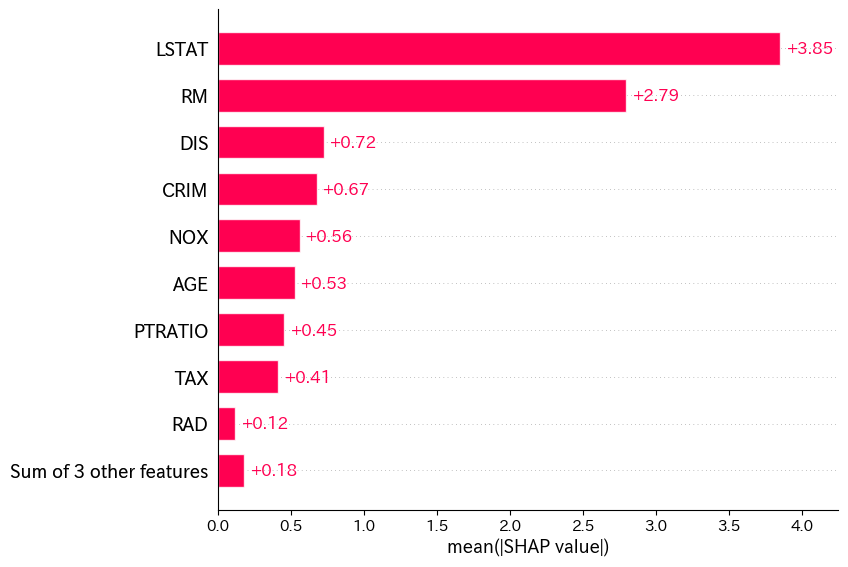

In [9]:
shap.plots.bar(shap_values)

【ML】SHAP


# https://takaherox.hatenablog.com/entry/2021/11/05/093507



In [4]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib # ここを追加するだけ
import lightgbm as lgb
import xgboost as xgb
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_curve
shap.initjs()
seed = 42
# データ読み込み
X,y = shap.datasets.adult()
X_display,y_display = shap.datasets.adult(display=True)
# カラム名変更
X.columns = [
    "年齢", "労働階級", "教育年数", "婚姻状態", "職業", "続柄",
    "人種", "性別", "資産売却益", "資産売却損", "労働時間", "出身国",
]
# 学習データセット作成
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_test = lgb.Dataset(X_test, label=y_test)
# パラメータ
params = {
    "objective": "binary",
    "metric": "auc",
}
# モデルの学習
lgb_m = lgb.train(
    params,
    lgb_train,
    10000,
    valid_sets=lgb_test,
    early_stopping_rounds=50,
    verbose_eval=1000,
)
# shap可視化
explainer = shap.TreeExplainer(model=lgb_model)
shap_values = explainer.shap_values(X=X_test)
shap.summary_plot(shap_values[1],X_test)

TypeError: train() got an unexpected keyword argument 'verbose_eval'

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
import xgboost as xgb
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_curve
shap.initjs()
seed = 42
# データ読み込み
X,y = shap.datasets.adult()
X_display,y_display = shap.datasets.adult(display=True)
# カラム名変更
X.columns = [
    "年齢", "労働階級", "教育年数", "婚姻状態", "職業", "続柄",
    "人種", "性別", "資産売却益", "資産売却損", "労働時間", "出身国",
]
# 学習データセット作成
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_test = lgb.Dataset(X_test, label=y_test)
# パラメータ
params = {
    "objective": "binary",
    "metric": "acu",
}
# モデルの学習
lgb_m = lgb.train(
    params,
    lgb_train,
    10000,
    valid_sets=lgb_test,
    early_stopping_rounds=50,
    verbose_eval=1000,
)
# shap可視化
explainer = shap.TreeExplainer(model=lgb_model)
shap_values = explainer.shap_values(X=X_test)
shap.summary_plot(shap_values[1],X_test)

TypeError: train() got an unexpected keyword argument 'early_stopping_rounds'

# 【ML】ボストンハウジング

https://zenn.dev/omochimaru/articles/2cd63904ce1913

https://datadriven-rnd.com/optuna_xgboost/

CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD  TAX  PTRATIO  \
0  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296     15.3   
1  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242     17.8   
2  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242     17.8   
3  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222     18.7   
4  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222     18.7   

        B  LSTAT  MEDV  
0  396.90   4.98  24.0  
1  396.90   9.14  21.6  
2  392.83   4.03  34.7  
3  394.63   2.94  33.4  
4  396.90   5.33  36.2

(506, 14)
CRIM       float64
ZN         float64
INDUS      float64
CHAS         int64
NOX        float64
RM         float64
AGE        float64
DIS        float64
RAD          int64
TAX          int64
PTRATIO    float64
B          float64
LSTAT      float64
MEDV       float64
dtype: object
CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64


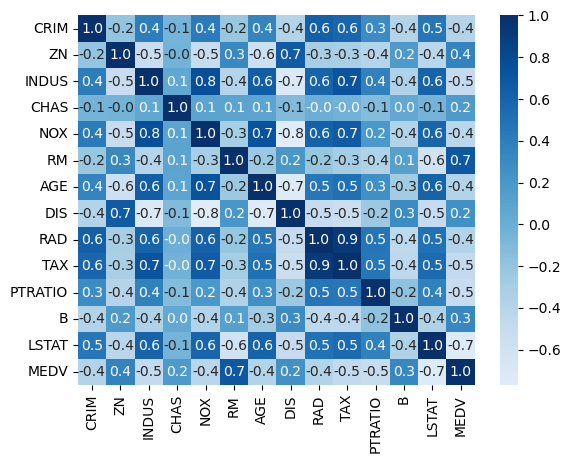

In [23]:
#データの取得
from sklearn import datasets
import pandas as pd
data=pd.read_csv('./dataset/BostonHousing_r.csv')
display(data.head())
print(data.shape) # (506, 13)
print(data.dtypes) # 全てfloat64
print(data.isnull().sum()) # 全て0
# ヒートマップで可視化
import seaborn as sns
import matplotlib.pyplot as plt
heat_map = data.corr(method="pearson")
sns.heatmap(heat_map,center=0,annot=True, cmap="Blues",fmt="1.1f")
plt.savefig('heat_map.png') # 画像の保存

# 単回帰分析　ボストンハウジング

https://zenn.dev/omochimaru/articles/2cd63904ce1913

回帰直線の切片 [-34.67062078]
回帰係数 [9.10210898]
決定係数 0.48352545599133423
回帰係数 y =  [9.10210898] x + [-34.67062078]


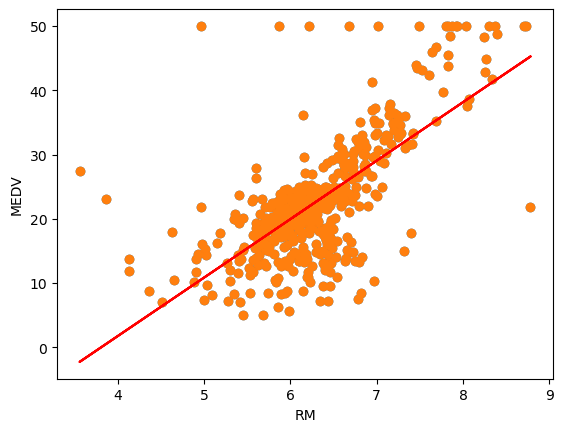

相関係数 0.695359947071539
相関係数^2（決定係数の2乗になっていることを確認） 0.48352545599133356
決定係数 0.48352545599133423


In [24]:
#データの取得
from sklearn import datasets
import pandas as pd
data=pd.read_csv('./dataset/BostonHousing_r.csv')
# 説明変数と目的変数を指定する
exp_var = 'RM' # 部屋数(RM)を説明変数
tar_var = 'MEDV' # 住宅価格(MEDV)を説明変数
# 説明変数をDataFrameにする
X = data[[exp_var]]
y = data[[tar_var]]
# 単回帰モデルを学習する
# 線形回帰による予測を行うクラスLinearRegression()をインストールする
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X, y)
print('回帰直線の切片', lr.intercept_)
print('回帰係数', lr.coef_[0])
print('決定係数', lr.score(X, y))
print('回帰係数', 'y = ', lr.coef_[0], 'x' , '+',  lr.intercept_)
plt.scatter(X, y) # 散布図を描画
plt.plot(X, lr.predict(X), color="r") # 回帰直線を赤い直線で描画
plt.xlabel(f"{exp_var}") 
plt.ylabel(f"{tar_var}")
plt.scatter(X, y) # 散布図を描画
plt.plot(X, lr.predict(X), color="r") # 回帰直線を赤い直線で描画
plt.xlabel(f"{exp_var}") 
plt.ylabel(f"{tar_var}")
plt.show()
import numpy as np
r = np.corrcoef(data['RM'], data['MEDV'])[0][1]
print('相関係数', r)
print('相関係数^2（決定係数の2乗になっていることを確認）', r ** 2)
print('決定係数',lr.score(X, y))

# 【重回帰】　ボストンハウジング

Ridge, Lasso


In [34]:
#データの取得
from sklearn import datasets
import pandas as pd
data=pd.read_csv('./dataset/BostonHousing_r.csv')
# 説明変数
exp_vars = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'LSTAT']
# 目的変数
tar_var = "MEDV"
X = data[exp_vars]
display(X.shape)
X.head()
y = data[tar_var]
display(y.shape)
y.head()
# train_data, test_dataに分割
# train_data : test_data = 8:2

# 訓練データとテストデータに分割するためのモデル
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_test', len(X_test))
print('y_test', len(y_test))

# データを標準化するためのモデル
from sklearn.preprocessing import StandardScaler
# X_trainを標準化する
scaler = StandardScaler()
scaler.fit(X_train) 
X_train_scaled = scaler.transform(X_train)
df_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
df_scaled.head(10) # 標準化されたデータの先頭10件 を試しに見てみる
# 学習
# 訓練データからパラメータ（回帰直線の傾き）を学習している
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

# 予測値の確認
y_pred = lr.predict(X_train_scaled)
y_pred[1:10]

# 偏回帰係数の確認
for xi, wi in zip(exp_vars, lr.coef_): # coef_は回帰直線の傾き
    # print(xi)
    # print(wi)
    # print(f'{xi, wi}')
    print('{0:7s}: {1:6.3f}'.format(xi, wi))

# 係数を降順に並び替える（係数が大きいと回帰直線に大きな影響を与えていると言える）
import numpy as np
for i in np.argsort(-lr.coef_):
    # print(i) # iには値が大きい順にインデックスが打たれている
    print('{0:7s}: {1:6.3f}'.format(exp_vars[i], lr.coef_[i]))
    
# 決定係数
# print("決定係数: {:.3f}".format(lr.score(X_test_scaled, y_test)))
w = pd.Series(index=exp_vars, data=lr.coef_)
np.linalg.norm(w, ord=2) # 重みベクトルwの L2ノルム
# np.linalg.norm(w) # 重みベクトルwの L1ノルム

# 訓練データに対するMSE
from sklearn.metrics import mean_squared_error
mse_train = mean_squared_error(y_train, y_pred)
print('訓練データに対するMSE', mse_train)

# テストデータに対するMSE
X_test_scaled = scaler.transform(X_test)
y_pred_test = lr.predict(X_test_scaled)
mse_test = mean_squared_error(y_test, y_pred_test)
print('テストデータに対するMSE', mse_test)


# Ridge回帰
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_scaled, y_train)
y_pred = ridge.predict(X_train_scaled)
# 偏回帰係数の確認
w_ridge = pd.Series(index=exp_vars, data=ridge.coef_)
for xi, wi in zip(exp_vars, ridge.coef_): # coef_は回帰直線の傾き
    # print(f'{xi, wi}')
    print('{0:7s}: {1:6.3f}'.format(xi, wi))
print('L2ノルム', np.linalg.norm(w_ridge))
# 訓練データに対するMSE
ridge_mse_train = mean_squared_error(y_train, y_pred)
print('訓練データに対するMSE', ridge_mse_train)
# テストデータに対するMSE
X_test_scaled = scaler.transform(X_test)
y_pred_test = ridge.predict(X_test_scaled)
ridge_mse_test = mean_squared_error(y_test, y_pred_test)
print('テストデータに対するMSE', ridge_mse_test)
# 決定係数
print("決定係数: {:.3f}".format(ridge.score(X_test_scaled, y_test)))
# Lasso回帰
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=1.0)
lasso.fit(X_train_scaled, y_train)
y_pred = lasso.predict(X_train_scaled)
# 偏回帰係数の確認
w_lasso = pd.Series(index=exp_vars, data=lasso.coef_)
for xi, wi in zip(exp_vars, lasso.coef_): # coef_は回帰直線の傾き
    # print(f'{xi, wi}')
    print('{0:7s}: {1:6.3f}'.format(xi, wi))
print('L2ノルム', np.linalg.norm(w_ridge))
# 訓練データに対するMSE
lasso_mse_train = mean_squared_error(y_train, y_pred)
print('訓練データに対するMSE', lasso_mse_train)
# テストデータに対するMSE
X_test_scaled = scaler.transform(X_test)
y_pred_test = lasso.predict(X_test_scaled)
lasso_mse_test = mean_squared_error(y_test, y_pred_test)
print('テストデータに対するMSE', lasso_mse_test)
# 決定係数
# print("決定係数: {:.3f}".format(lasso.score(X_test_scaled, y_test)))
# 精度の比較
data = {'訓練データMSE':[mse_train, ridge_mse_train, lasso_mse_train], 
        'テストデータMSE':[mse_test, ridge_mse_test, lasso_mse_test], 
        '決定係数':[lr.score(X_test_scaled, y_test), ridge.score(X_test_scaled, y_test), lasso.score(X_test_scaled, y_test)]}
df_mse = pd.DataFrame(data=data, index=['重回帰', 'Ridge', 'Lasso'])
df_mse

(506, 12)

(506,)

X_train (404, 12)
y_train (404,)
X_test 102
y_test 102
CRIM   : -0.979
ZN     :  1.077
INDUS  :  0.003
CHAS   :  0.645
NOX    : -1.963
RM     :  2.466
AGE    :  0.026
DIS    : -2.923
RAD    :  1.920
TAX    : -1.893
PTRATIO: -2.247
LSTAT  : -3.850
RM     :  2.466
RAD    :  1.920
ZN     :  1.077
CHAS   :  0.645
AGE    :  0.026
INDUS  :  0.003
CRIM   : -0.979
TAX    : -1.893
NOX    : -1.963
PTRATIO: -2.247
DIS    : -2.923
LSTAT  : -3.850
訓練データに対するMSE 19.70084754295569
テストデータに対するMSE 34.39506346464681
CRIM   : -0.971
ZN     :  1.060
INDUS  : -0.023
CHAS   :  0.649
NOX    : -1.927
RM     :  2.478
AGE    :  0.016
DIS    : -2.890
RAD    :  1.846
TAX    : -1.826
PTRATIO: -2.238
LSTAT  : -3.831
L2ノルム 6.8648220303164775
訓練データに対するMSE 19.70210375727289
テストデータに対するMSE 34.48215906163192
決定係数: 0.577
CRIM   : -0.000
ZN     :  0.000
INDUS  : -0.000
CHAS   :  0.000
NOX    : -0.000
RM     :  2.525
AGE    : -0.000
DIS    : -0.000
RAD    : -0.000
TAX    : -0.207
PTRATIO: -1.779
LSTAT  : -3.622
L2ノルム 6.864822

訓練データMSE  テストデータMSE      決定係数
重回帰    19.700848  34.395063  0.577604
Ridge  19.702104  34.482159  0.576534
Lasso  25.102445  40.412699  0.503703

# Optuna 最適化　ボストンハウジング

https://datadriven-rnd.com/optuna_xgboost/

In [39]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score
# from sklearn.datasets import load_boston
import optuna
import xgboost as xgb
#データの取得
from sklearn import datasets
import pandas as pd
data=pd.read_csv('./dataset/BostonHousing_r.csv')
# 説明変数
exp_vars = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'LSTAT']
# 目的変数
tar_var = "MEDV"
# boston = load_boston()
df_X = data[exp_vars]
display(df_X.shape)
df_X.head()
df_y = data[tar_var]
display(df_y.shape)
df_y.head()
# df_X = pd.DataFrame(boston.data, columns=boston.feature_names)
# df_y = pd.DataFrame(boston.target,columns=['Price'])
def objective(trial,df_X,df_y):
    #評価するハイパーパラメータの値を規定
    params ={
        'max_depth':trial.suggest_int("max_depth",1,10),
        'min_child_weight':trial.suggest_int('min_child_weight',1,5),
        'gamma':trial.suggest_uniform('gamma',0,1),
        'subsample':trial.suggest_uniform('subsample',0,1),
        'colsample_bytree':trial.suggest_uniform('colsample_bytree',0,1),
        'reg_alpha':trial.suggest_loguniform('reg_alpha',1e-5,100),
        'reg_lambda':trial.suggest_loguniform('reg_lambda',1e-5,100),        
        'learning_rate':trial.suggest_uniform('learning_rate',0,1)}
    model = xgb.XGBRegressor(n_estimators=100,
                            verbosity=0,
                            n_jobs=-1,
                            random_state=0,
                            **params)
    #交差検証
    scores = cross_val_score(model, df_X, df_y, scoring='neg_mean_squared_error',cv=5)
    score_mean = -1 * np.mean(scores)
    return score_mean
#optuna.create_study()でoptuna.studyインスタンスを作る。
study = optuna.create_study()
#studyインスタンスのoptimize()に作った関数を渡して最適化する。
study.optimize(lambda trial: objective(trial,df_X,df_y), n_trials=100)
#下記のような感じで計算過程が表示される
"""output
[I 2021-09-15 23:12:31,860] A new study created in memory with name: no-name-1c966f32-0143-4277-89a9-737785ecff73
[I 2021-09-15 23:12:32,538] Trial 0 finished with value: 21.953465964005716 and parameters: {'max_depth': 10, 'min_child_weight': 2, 'gamma': 0.7239605433055278, 'subsample': 0.43807900497034136, 'colsample_bytree': 0.2881615006892957, 'reg_alpha': 5.510000819738757e-05, 'reg_lambda': 61.06698592300022, 'learning_rate': 0.41400609846451486}. Best is trial 0 with value: 21.953465964005716.
[I 2021-09-15 23:12:33,586] Trial 1 finished with value: 20.380537482594693 and parameters: {'max_depth': 7, 'min_child_weight': 4, 'gamma': 0.022923877570006024, 'subsample': 0.9185493358622109, 'colsample_bytree': 0.6657960975739451, 'reg_alpha': 0.1270258763328784, 'reg_lambda': 31.66101345986972, 'learning_rate': 0.25690666578645205}. Best is trial 1 with value: 20.380537482594693.
[I 2021-09-15 23:12:34,523] Trial 2 finished with value: 20.995102527541384 and parameters: {'max_depth': 8, 'min_child_weight': 3, 'gamma': 0.08042752498848993, 'subsample': 0.8122586312076105, 'colsample_bytree': 0.6472068995951297, 'reg_alpha': 0.8193181134698155, 'reg_lambda': 22.35699024120949, 'learning_rate': 0.3523914200916791}. Best is trial 1 with value: 20.380537482594693.
····
"""
#スコアを見る
print(study.best_params)    
print(study.best_value)

(506, 12)

(506,)

0    24.0
1    21.6
2    34.7
3    33.4
4    36.2
Name: MEDV, dtype: float64

# XGBoostをOptuna

https://www.inoue-kobo.com/ai_ml/xgboost-with-optuna/

# 【ML】決定木　キノコ

tree_mashroom.py

データの形式:(8124, 23)
欠損の数:0
毒キノコデータのエントロピーの初期値: 0.999
entropy_c0: 0.999
entropy_c1: 0.845
データ分割後の平均エントロピー: 0.998
変数cap_colorの分割によって得られる情報利得: 0.001
変数gill_colorの分割によって得られる情報利得: 0.269


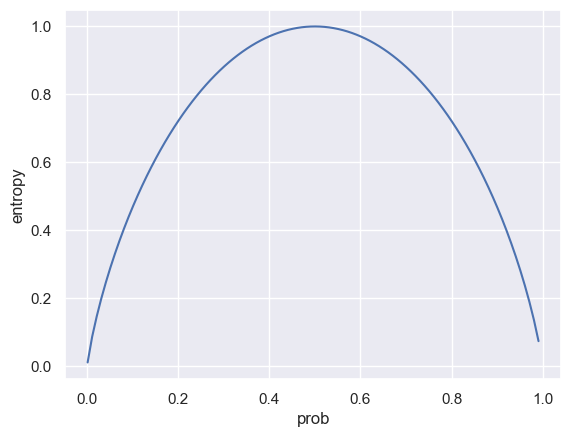

In [27]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data'
res = requests.get(url).content
mushroom = pd.read_csv(io.StringIO(res.decode('utf-8')), header=None)
mushroom.columns =['classes','cap_shape','cap_surface','cap_color','odor','bruises',
                             'gill_attachment','gill_spacing','gill_size','gill_color','stalk_shape',
                             'stalk_root','stalk_surface_above_ring','stalk_surface_below_ring',
                             'stalk_color_above_ring','stalk_color_below_ring','veil_type','veil_color',
                             'ring_number','ring_type','spore_print_color','population','habitat']
# mushroom.head()
print('データの形式:{}'.format(mushroom.shape))
print('欠損の数:{}'.format(mushroom.isnull().sum().sum()))
mushroom_dummy = pd.get_dummies(mushroom[['gill_color','gill_attachment','odor','cap_color']])
mushroom_dummy.head()
# 目的変数もフラグ化（0/1化）する
mushroom_dummy['flg'] = mushroom['classes'].map(lambda x: 1 if x =='p' else 0)
mushroom_dummy.groupby(['cap_color_c', 'flg'])['flg'].count().unstack()
mushroom_dummy.groupby(['gill_color_b', 'flg'])['flg'].count().unstack()
# - (0.5 * np.log2(0.5) + 0.5 * np.log2(0.5))
# - (0.001 * np.log2(0.001) + 0.999 * np.log2(0.999))
def calc_entropy(p):
    return - (p * np.log2(p) + (1 - p) *  np.log2(1 - p) )
# pの値を0.001から0.999まで0.01刻みで動かす
p = np.arange(0.001, 0.999, 0.01)
# グラフ化
plt.plot(p, calc_entropy(p)) 
plt.xlabel('prob')
plt.ylabel('entropy')
plt.grid(True)
mushroom_dummy.groupby('flg')['flg'].count()
entropy_init = - (0.518 * np.log2(0.518) + 0.482 * np.log2(0.482))
print('毒キノコデータのエントロピーの初期値: {:.3f}'.format(entropy_init))
mushroom_dummy.groupby(['cap_color_c', 'flg'])['flg'].count().unstack()
# cap_colorがcでない場合のエントロピー
p1 = 4176 / (4176 + 3904)
p2 = 1 - p1
entropy_c0 = -(p1*np.log2(p1)+p2*np.log2(p2))
print('entropy_c0: {:.3f}'.format(entropy_c0))
# cap_colorがcである場合のエントロピー
p1 = 32/(32+12)
p2 = 1 - p1
entropy_c1 = -(p1*np.log2(p1)+p2*np.log2(p2))
print('entropy_c1: {:.3f}'.format(entropy_c1))
entropy_after = (4176+3904)/8124*entropy_c0 + (32+12)/8124*entropy_c1
print('データ分割後の平均エントロピー: {:.3f}'.format(entropy_after))
print('変数cap_colorの分割によって得られる情報利得: {:.3f}'.format(entropy_init - entropy_after))
mushroom_dummy.groupby(['gill_color_b', 'flg'])['flg'].count().unstack()
# gill_colorがbでない場合のエントロピー
p1 = 4208/(4208+2188)
p2 = 1 - p1
entropy_b0 = - (p1*np.log2(p1) + p2*np.log2(p2))

# gill_colorがbである場合のエントロピー
p1 = 0/(0+1728)
p2 = 1 - p1
entropy_b1 = - (p2*np.log2(p2))

entropy_after = (4208+2188)/8124*entropy_b0 + (0+1728)/8124*entropy_b1
print('変数gill_colorの分割によって得られる情報利得: {:.3f}'.format(entropy_init - entropy_after))

# 【ML】決定木　キノコ


In [5]:
from sklearn.tree import  DecisionTreeClassifier
from sklearn.model_selection import train_test_split
X = mushroom_dummy.drop('flg', axis=1)
y = mushroom_dummy['flg']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
model = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=0)
model.fit(X_train,y_train)
print('正解率(train):{:.3f}'.format(model.score(X_train, y_train)))
print('正解率(test):{:.3f}'.format(model.score(X_test, y_test)))
from sklearn.datasets import load_iris
from sklearn import tree
import pydotplus
from six import StringIO
from IPython.display import Image
# 参考プログラム
# pydotplusやgraphvizをインストールする必要があります
from sklearn import tree
import pydotplus
from sklearn.externals.six import StringIO
from IPython.display import Image

dot_data = StringIO()
tree.export_graphviz(model, out_file=dot_data)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())


NameError: name 'mushroom_dummy' is not defined

# 【ML】重回帰

自動車価格データの取り込み


使用した公開データ
http://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data

In [6]:
import numpy as np
import numpy.random as random
import scipy as sp
from pandas import Series, DataFrame
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline
# 機械学習ライブラリ
import sklearn
# 小数第3位まで表示
%precision 3
# インポート
import requests, zipfile
import io
# 自動車価格データを取得
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data'
res = requests.get(url).content
# 取得したデータをDataFrameオブジェクトとして読み込み
auto = pd.read_csv(io.StringIO(res.decode('utf-8')), header=None)
# データの列にラベルを設定
auto.columns =['symboling','normalized-losses','make','fuel-type' ,'aspiration','num-of-doors',
                            'body-style','drive-wheels','engine-location','wheel-base','length','width','height',
                            'curb-weight','engine-type','num-of-cylinders','engine-size','fuel-system','bore',
                            'stroke','compression-ratio','horsepower','peak-rpm','city-mpg','highway-mpg','price']
print('自動車データの形式:{}'.format(auto.shape))
# auto.head()
# それぞれのカラムに ? が何個あるかカウント
auto = auto[['price','horsepower','width','height']]
auto.isin(['?']).sum()
# '?'をNaNに置換して、NaNがある行を削除
auto = auto.replace('?', np.nan).dropna()
print('自動車データの形式:{}'.format(auto.shape))
print('データ型の確認（型変換前）\n{}\n'.format(auto.dtypes))
auto = auto.assign(price=pd.to_numeric(auto.price))
auto = auto.assign(horsepower=pd.to_numeric(auto.horsepower))
print('データ型の確認（型変換後）\n{}'.format(auto.dtypes))
auto.corr()
# データ分割（訓練データとテストデータ）のためのインポート
from sklearn.model_selection import train_test_split
# 重回帰のモデル構築のためのインポート
from sklearn.linear_model import LinearRegression
 # 目的変数にpriceを指定、説明変数にそれ以外を指定
X = auto.drop('price', axis=1)
y = auto['price']
# 訓練データとテストデータに分ける
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)
# 重回帰クラスの初期化と学習
model = LinearRegression()
model.fit(X_train,y_train)
# 決定係数を表示
print('決定係数(train):{:.3f}'.format(model.score(X_train,y_train)))
print('決定係数(test):{:.3f}'.format(model.score(X_test,y_test)))
# 回帰係数と切片を表示
print('\n回帰係数\n{}'.format(pd.Series(model.coef_, index=X.columns)))
print('切片: {:.3f}'.format(model.intercept_))

自動車データの形式:(205, 26)
自動車データの形式:(199, 4)
データ型の確認（型変換前）
price          object
horsepower     object
width         float64
height        float64
dtype: object

データ型の確認（型変換後）
price           int64
horsepower      int64
width         float64
height        float64
dtype: object
決定係数(train):0.733
決定係数(test):0.737

回帰係数
horsepower      81.651078
width         1829.174506
height         229.510077
dtype: float64
切片: -128409.046


# 【ML】リッジ回帰

In [12]:
# auto.head()
# リッジ回帰用のクラス
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split

# 訓練データとテストデータに分割
X = auto.drop('price', axis=1)
y = auto['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

# モデルの構築と評価
linear = LinearRegression()
ridge = Ridge(random_state=0)

for model in [linear, ridge]:
    model.fit(X_train,y_train)
    print('{}(train):{:.6f}'.format(model.__class__.__name__ , model.score(X_train,y_train)))
    print('{}(test):{:.6f}'.format(model.__class__.__name__ , model.score(X_test,y_test)))

LinearRegression(train):0.733358
LinearRegression(test):0.737069
Ridge(train):0.733355
Ridge(test):0.737768


# 【ML】サポートベクターマシンのモデル構築　乳がん

SVC_beast.py

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, stratify = cancer.target, random_state=0)
model = LinearSVC()
model.fit(X_train,y_train)
print('正解率(train):{:.3f}'.format(model.score(X_train, y_train)))
print('正解率(test):{:.3f}'.format(model.score(X_test, y_test)))

正解率(train):0.932
正解率(test):0.930


C:\Users\user\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [10]:
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, stratify = cancer.target, random_state=0)
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)
model = LinearSVC()
model.fit(X_train_std,y_train)
print('正解率(train):{:.3f}'.format(model.score(X_train_std, y_train)))
print('正解率(test):{:.3f}'.format(model.score(X_test_std, y_test)))

正解率(train):0.993
正解率(test):0.951


# 【ML】k分割交差検証　乳がんデータ

cross_val_breast.py

In [2]:
import numpy as np
import numpy.random as random
import scipy as sp
from pandas import Series,DataFrame
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline
sns.set()
import sklearn
%precision 3
from sklearn.datasets import load_breast_cancer
from sklearn.tree import  DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
# 乳がんのデータを読み込み
cancer = load_breast_cancer()
# 決定木クラスの初期化
tree = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)
# k分割交差検証の実行
scores = cross_val_score(tree, cancer.data, cancer.target, cv=5)
# 結果の表示
print('Cross validation scores: {}'.format(scores))
print('Cross validation scores: {:.3f}+-{:.3f}'.format(scores.mean(), scores.std()))

Cross validation scores: [0.904 0.912 0.956 0.939 0.956]
Cross validation scores: 0.933+-0.022


# 【ML】ハイパーパラメータチューニング　グリッドサーチ1

split_SVC_breadst.py

ベストスコア:0.91
その時のパラメータ(gamma, C):(0.001, 1.0)


<Axes: >

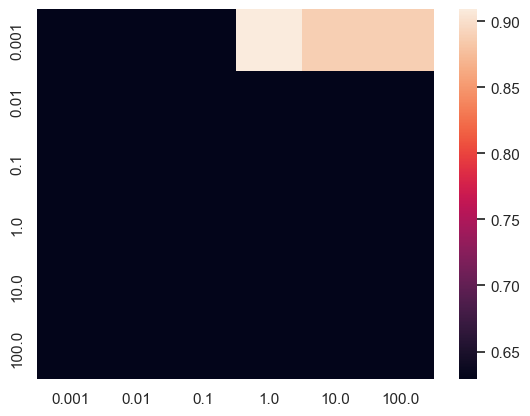

In [3]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data,
                                                    cancer.target,
                                                    stratify = cancer.target,
                                                    random_state=0)
scores = {}
for gamma in np.logspace(-3, 2, num=6):
    for C in np.logspace(-3, 2, num=6):
        svm = SVC(gamma=gamma, C=C)
        svm.fit(X_train,y_train)
        scores[(gamma, C)] = svm.score(X_test, y_test)
scores = pd.Series(scores)
print('ベストスコア:{:.2f}'.format(scores.max()))
print('その時のパラメータ(gamma, C):{}'.format(scores.idxmax()))
sns.heatmap(scores.unstack())

# 【ML】ハイパーパラメータチューニング　グリッドサーチ2

gs_SVC_breast.py

In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data,
                                                    cancer.target,
                                                    stratify = cancer.target,
                                                    random_state=0)
# GridSearchCVクラスに与えるパラメータを準備
param_grid = { 'C': np.logspace(-3, 2, num=6)
               ,'gamma':np.logspace(-3, 2, num=6)}
# GridSearchCVクラスの初期化
gs = GridSearchCV(estimator=SVC(),
                  param_grid=param_grid,
                  cv=5)
# ハイパーパラメータの組み合わせの検証とベストモデルの構築
gs.fit(X_train,y_train)
print('Best cross validation score:{:.3f}'.format(gs.best_score_))
print('Best parameters:{}'.format(gs.best_params_))
print('Test score:{:.3f}'.format(gs.score(X_test,y_test)))

Best cross validation score:0.925
Best parameters:{'C': 1.0, 'gamma': 0.001}
Test score:0.909


# 【STAT】kmeansクラスタリング

差別理由でデータが使えなくなった例


CRIM： 町別の「犯罪率」
ZN： 25,000平方フィートを超える区画に分類される住宅地の割合＝「広い家の割合」
INDUS： 町別の「非小売業の割合」
CHAS： チャールズ川のダミー変数（区画が川に接している場合は1、そうでない場合は0）＝「川の隣か」
NOX： 「NOx濃度（0.1ppm単位）」＝一酸化窒素濃度（parts per 10 million単位）。この項目を目的変数とする場合もある
RM： 1戸当たりの「平均部屋数」
AGE： 1940年より前に建てられた持ち家の割合＝「古い家の割合」
DIS： 5つあるボストン雇用センターまでの加重距離＝「主要施設への距離」
RAD： 「主要高速道路へのアクセス性」の指数
TAX： 10,000ドル当たりの「固定資産税率」
PTRATIO： 町別の「生徒と先生の比率」
B： 「1000(Bk - 0.63)」の二乗値。Bk＝「町ごとの黒人の割合」を指す
LSTAT： 「低所得者人口の割合」
MEDV：「住宅価格」（1000ドル単位）の中央値。通常はこの数値が目的変数として使われる

https://note.com/nishihiro_o/n/na9ccdaa691f1#d844e5dc-7e6b-453d-94e4-d3da8ed2fce8

C:\Users\user\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


<Axes: xlabel='cluster', ylabel='rad'>

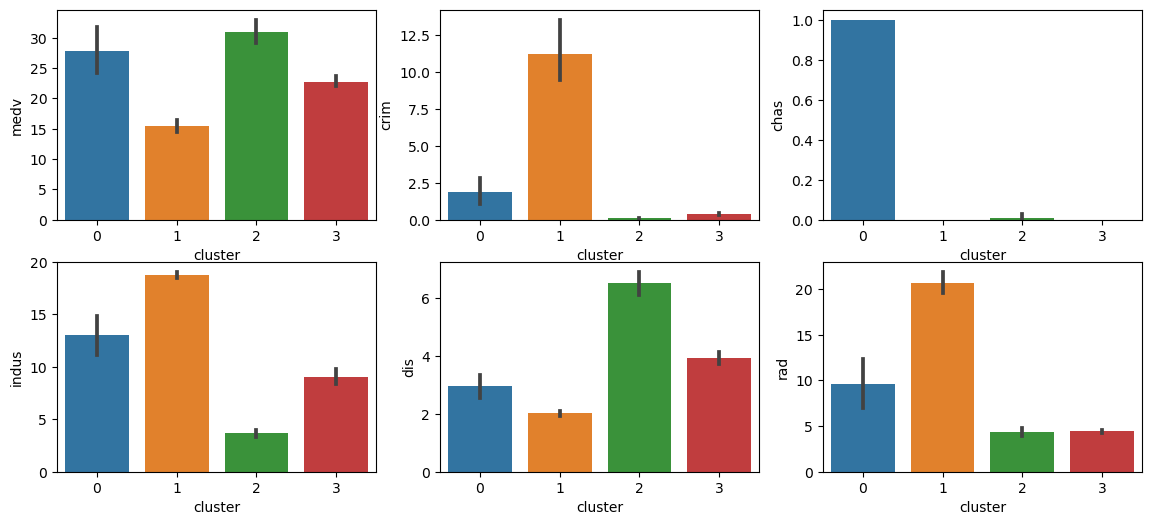

In [7]:
#データの取得
from sklearn import datasets
import pandas as pd
df=pd.read_csv('./dataset/BostonHousing.csv')
# df.head()
# boston = datasets.load_boston()
# df = pd.DataFrame(boston.data, columns=boston.feature_names)
# df['MEDV'] = boston.target
# print(boston_df)
# boston_df.head()
#  #欠損値の確認 
# df.isnull().sum()
 #データの標準化 
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
df_sc = sc.fit_transform(df)
df_sc = pd.DataFrame(df_sc, columns=df.columns)
#クラスタリングを実行
from sklearn.cluster import KMeans
model = KMeans(n_clusters=4, random_state=1)
model.fit(df_sc)
#クラスタ番号の取得 
cluster = model.labels_
#クラスタ番号の追加 
df['cluster'] = cluster
#クラスタリングの結果を確認
df.groupby('cluster').mean().style.bar(axis=0)
 #クラスタリングの結果を棒グラフに反映 
import matplotlib.pyplot as plt
import seaborn as sb
fig, axes = plt.subplots(2,3, figsize=(14, 6))
sb.barplot(ax=axes[0,0], data=df, x='cluster', y='medv')
sb.barplot(ax=axes[0,1], data=df, x='cluster', y='crim')
sb.barplot(ax=axes[0,2], data=df, x='cluster', y='chas')
sb.barplot(ax=axes[1,0], data=df, x='cluster', y='indus')
sb.barplot(ax=axes[1,1], data=df, x='cluster', y='dis')
sb.barplot(ax=axes[1,2], data=df, x='cluster', y='rad')

# 【STAT】主成分分析

PCA

うまく分離できない？


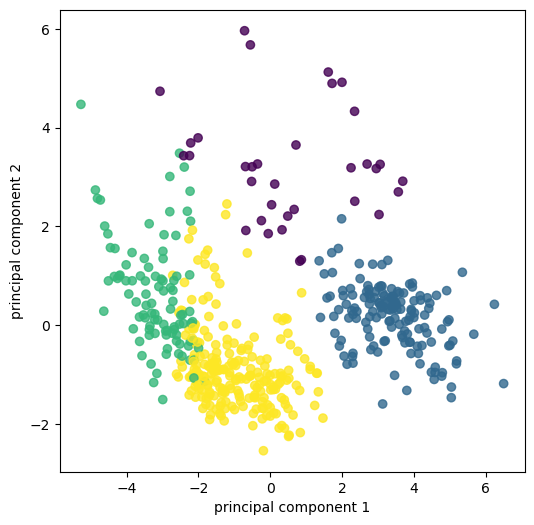

In [28]:
 #標準化したデータフレームにクラスタ番号の追加 
df_sc['cluster'] = cluster
 #主成分を指定 
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=1)
pca.fit(df_sc)
feature = pca.transform(df_sc)
#　データを散布図で可視化
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 6))
plt.scatter(feature[:, 0], feature[:, 1], alpha=0.8, c=cluster)
plt.xlabel('principal component 1')
plt.ylabel('principal component 2')
plt.show()

# 【ML】決定木の可視化（グラフプロット）

【AI】機械学習 by Python：決定木の描画②～Graphvizを使ってJupyter Notebook上に直接描画する方法～
https://pictblog.com/ai-decisiontree-draw-2

tree.py

分割の確認： (80, 2) (20, 2) (80,) (20,)
正解率(学習データ) =  1.0
正解率(テストデータ) =  1.0


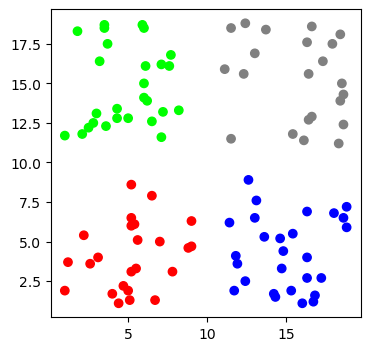

In [30]:
# モジュールのインポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import ListedColormap
import sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
# データセットのインポート
file=pd.read_csv('tree.csv')
# データの割り振り
X=file.iloc[:,0:2]
Y=file.iloc[:,2]
# データセットを学習データ（8割）とテストデータ（2割）に分割（random_stateは0）
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X, Y, test_size=0.2, random_state=0)
# 分割の確認
print('分割の確認：',X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)
# 学習実行
# インスタンスの作成
model = DecisionTreeClassifier(max_depth=2)
# モデルの作成
model.fit(X_train, Y_train)
# 学習データからの予測値
pred_train = model.predict(X_train)
# テストデータからの予測値
pred_test = model.predict(X_test)
# 学習データを用いた分類モデルの評価
print('正解率(学習データ) = ', metrics.accuracy_score(Y_train, pred_train))
# テストデータを用いた分類モデルの評価
print('正解率(テストデータ) = ', metrics.accuracy_score(Y_test, pred_test))
# データセットの図示
plt.figure(figsize=(4,4))
plt.scatter(file.iloc[:,0], file.iloc[:,1], c=file.iloc[:,2], cmap=ListedColormap(['#FF0000', '#0000FF','#00FF00','#808080']))
plt.show()

# 【ML】決定木の可視化（Graphviz）

dotplusをサイトからダウンロードして、それを実行することでインストール

システム環境変数で、PATHに下記設定

C:\Program Files\Graphviz\bin

【AI】機械学習 by Python：決定木の描画②～Graphvizを使ってJupyter Notebook上に直接描画する方法～
https://pictblog.com/ai-decisiontree-draw-2

In [33]:
# graphvizで描画(Jupyter Notebookに直接)
# import pydot
from sklearn.tree import export_graphviz
from IPython import display
import pydotplus
from six import StringIO
from IPython.display import Image
import webbrowser
test_feature = ['x', 'y']
test_class = ['0','1','2','3']
dot_str = export_graphviz(
    model.fit(X_train, Y_train), #学習で得られたモデルのコード。
    filled = True, #ノードに色をつけるためのコード。
    rounded = True, #ノードの角を丸くするコード。
    feature_names = test_feature, #説明変数(特徴量)の名前を指定するコード。
    class_names = test_class #目的変数(カテゴリー)の名前を指定するコード。
)
graphs = pydotplus.graph_from_dot_data(dot_str)
PdfFile="OutputTree.pdf"
graphs.write_pdf(PdfFile)
# Image(graphs.create_png())
webbrowser.open_new(PdfFile)
# png_data = graphs[0].create_png(prog='dot')
# display.display(display.Image(png_data))

True

# 【ML】pydotplusの出力


In [31]:
import pydotplus
graph=pydotplus.graph_from_dot_file('test.dot')
graph.write_svg('test.svg')

True

# 【ML】アヤメデータ決定木可視化

scikit-learnとTensorFlowによる実践機械学習, 6.2 決定木による予測

iris_tree.py

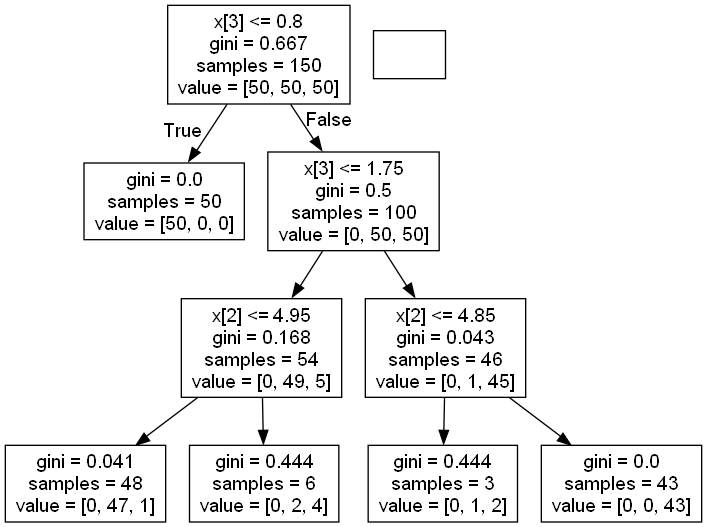

In [1]:
from sklearn.datasets import load_iris
from sklearn import tree
import pydotplus
from six import StringIO
from IPython.display import Image
import webbrowser
iris = load_iris()
#iris.data
#iris.target
clf = tree.DecisionTreeClassifier(max_depth=3)
clf = clf.fit(iris.data, iris.target)
predicted = clf.predict(iris.data)
#predicted
#sum(predicted == iris.target) / len(iris.target)
tree.export_graphviz(clf, out_file="tree.dot",
                     feature_names=iris.feature_names,
                     class_names=iris.target_names,
                     filled=True, 
                     rounded=True)
dot_data = StringIO()
tree.export_graphviz(clf, out_file=dot_data)
graphs = pydotplus.graph_from_dot_data(dot_data.getvalue())
PdfFile="IrisTree.pdf"
# graph.write_Pdf(PdfFile)
# graphs.write_pdf(PdfFile)
Image(graphs.create_png())
# webbrowser.open_new(PdfFile)

In [34]:
from sklearn.datasets import load_iris
from sklearn import tree
from sklearn.externals.six import StringIO
import pydotplus #pydotplusに変更
if __name__ == "__main__":
    #irisデータの読み込み
    iris = load_iris()
    #決定木学習
    clf = tree.DecisionTreeClassifier()
    clf.fit(iris.data, iris.target)
    #決定木モデルの書き出し
    dot_data = StringIO()
    tree.export_graphviz(clf, out_file=dot_data,  
                         feature_names=iris.feature_names,  
                         class_names=iris.target_names,  
                         filled=True, rounded=True,  
                         special_characters=True) 
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  #pydotplusに変更
    graph.write_png("iris.png") 

ModuleNotFoundError: No module named 'sklearn.externals.six'

# 【ML】ボストンハウジングのデータ可視化

いまにゅ

【完全版】この動画1本で機械学習実装（Python）の基礎を習得！忙しい人のための速習コース

https://www.youtube.com/watch?v=okpRV08-svw

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# from sklearn.datasets import load_boston
df=pd.read_csv('./dataset/BostonHousing.csv')
# dataset=load_boston()
# x, t =dataset.data, dataset.target
# columns=dataset.feature_names
# type(x), x.shape
# type(t), t.shape
# columns
# df=pd.DataFrame(x, columns=columns)
# df.head()
# df['Target']=t
# df.head()
# t=df['Target'].values
# x=df.drop(labels=['Target'], axis=1)
t=df['medv'].values
x=df.drop(labels=['medv'], axis=1)
from sklearn.model_selection import train_test_split
x_train, x_test, t_train, t_test=train_test_split(x, t, test_size=0.3, random_state=0)
# len(x_test)
from sklearn.linear_model import LinearRegression
model=LinearRegression()
# model
model.fit(x_train,t_train)
model.coef_
plt.figure(figsize=(10,7))

columns=['crim','zn','indus','chas','nox','rm','age','dis','rad','tax','ptratio','b','lstat']
plt.bar(x=columns, height=model.coef_)

crim    zn  indus  chas    nox     rm   age     dis  rad  tax  ptratio  \
0  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296     15.3   
1  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242     17.8   
2  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242     17.8   
3  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222     18.7   
4  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222     18.7   

        b  lstat  medv  
0  396.90   4.98  24.0  
1  396.90   9.14  21.6  
2  392.83   4.03  34.7  
3  394.63   2.94  33.4  
4  396.90   5.33  36.2

# 【ML】教師あり学習：回帰

いまにゅ

【完全版】この動画1本で機械学習実装（Python）の基礎を習得！忙しい人のための速習コース

https://www.youtube.com/watch?v=okpRV08-svw

train score: 0.9365474967006422
test score: -0.008361798630077244
予測値：-2.7696643604140263
目標値：-2.64
train score: 0.9365474967006422
test score: -0.008361798630077244


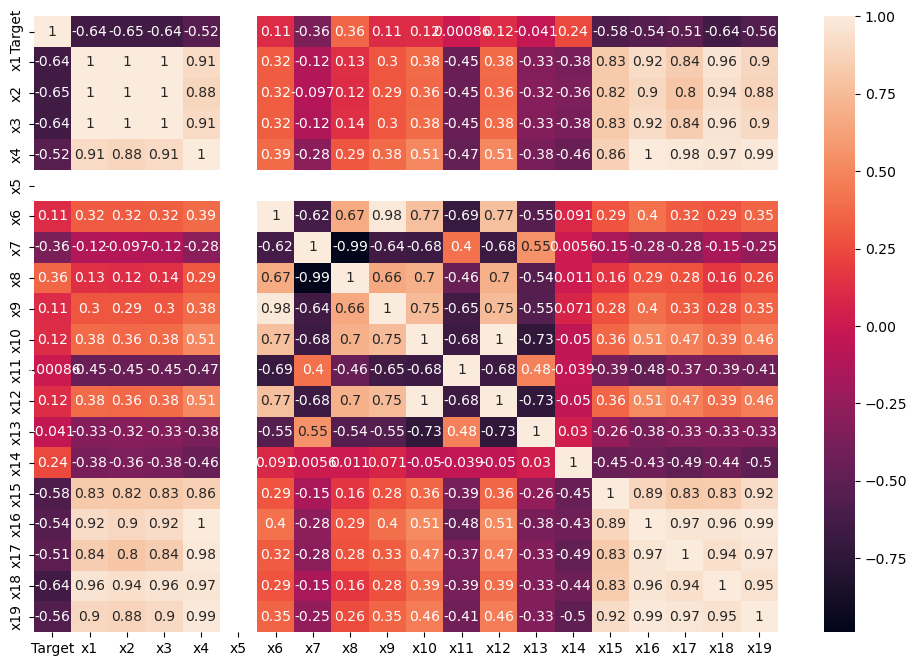

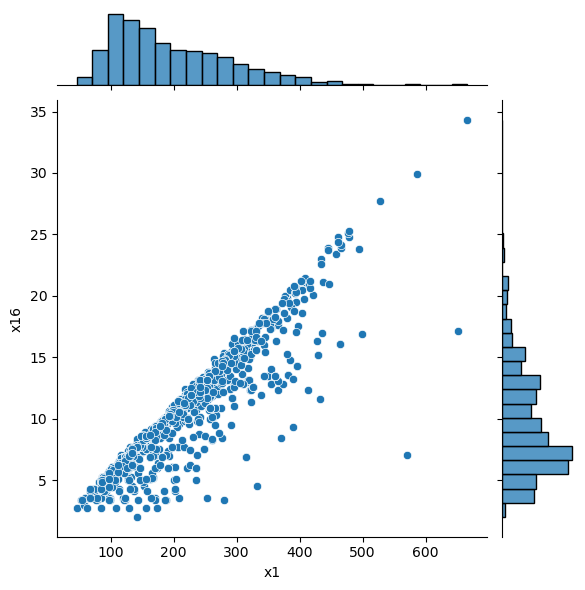

In [60]:
model.intercept_
print(f'train score: {model.score(x_train, t_train)}')
print(f'test score: {model.score(x_test, t_test)}')
y=model.predict(x_test)
print(f'予測値：{y[1]}')
print(f'目標値：{t_test[1]}')
# 過学習
df=pd.read_csv('regression_pls.csv')
df.head()
df.shape
t=df['Target'].values
x=df.drop('Target', axis=1).values
t.shape
x.shape
x_train, x_test,t_train, t_test=train_test_split(x, t, test_size=0.3, random_state=0)
model.fit(x_train, t_train)
print(f'train score: {model.score(x_train, t_train)}')
print(f'test score: {model.score(x_test, t_test)}')
df_corr=df.corr()
plt.figure(figsize=(12,8))
sns.heatmap(df_corr.iloc[:20, :20], annot=True)
sns.jointplot(x='x1', y='x16', data=df)

# 【ML】教師あり学習：回帰

PLS

多重共線性を改善

ハイパーパラメータ調整の重要性

いまにゅ

【完全版】この動画1本で機械学習実装（Python）の基礎を習得！忙しい人のための速習コース

https://www.youtube.com/watch?v=okpRV08-svw


In [61]:
from sklearn.cross_decomposition import PLSRegression
pls=PLSRegression(n_components=11)
pls.fit(x_train, t_train)
print(f'train score: {pls.score(x_train, t_train)}')
print(f'test score: {pls.score(x_test, t_test)}')

train score: 0.9157705245807128
test score: 0.8839475118318953


# 【ML】教師あり学習（分類）決定木 ×　木の可視化がうまくいかない（上にうまくいったのがある）

アヤメのデータセット

決定木

いまにゅ

【完全版】この動画1本で機械学習実装（Python）の基礎を習得！忙しい人のための速習コース

https://www.youtube.com/watch?v=okpRV08-svw

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
import subprocess
dataset=load_iris()
columns_name=dataset.feature_names
x=dataset.data
t=dataset.target
# np.unique(t)
# x.shape
# t.shape
from sklearn.model_selection import train_test_split
x_train, x_test, t_train, t_test=train_test_split(x, t, test_size=0.3, random_state=0)
# x_test.shape
from sklearn.tree import DecisionTreeClassifier
model=DecisionTreeClassifier(random_state=0)
model.fit(x_train, t_train)
# print(f'train score: {model.score(x_train, t_train)}')
# print(f'test score: {model.score(x_test, t_test)}')
model.predict(x_test)

# 決定木
import graphviz
from sklearn.tree import export_graphviz
dot_data=export_graphviz(model)
# export_graphviz(model, "tree1.2.dot",
#                 feature_names=x_train.feature_names,
#                 class_names=t_train.target_names)
# subprocess.run("model -Tpng tree1.2.dot -o tree1.2.png".split())

ModuleNotFoundError: No module named 'graphviz'

In [ ]:
graph_tree=graphviz.Source(dot_data)
# ×ツリーがビジュアル化できない
graph_tree

In [ ]:
# dot_data.render('./example1.gv', view=True)
# print(graph_tree)

In [ ]:
feature_importance=model.feature_importances_
feature_importance

In [ ]:
y=columns_name
width=feature_importance

In [ ]:
plt.barh(y=y, width=width)

# 【ML】教師あり学習（分類）　SVM サポートベクトルマシン

サポートベクトルマシン

いまにゅ
【完全版】この動画1本で機械学習実装（Python）の基礎を習得！忙しい人のための速習コース

https://www.youtube.com/watch?v=okpRV08-svw

In [76]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
from sklearn.svm import SVC
# import subprocess
# dataset=load_iris()
model=SVC()
model.fit(x_train, t_train)
print(f'train score: {model.score(x_train, t_train)}')
print(f'test score: {model.score(x_test, t_test)}')
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaler.fit(x_train)
x_train_std=scaler.transform(x_train)
x_test_std=scaler.transform(x_test)
round(x_train_std.std())
# C ハイパーパラメータ
model_std=SVC(C=10, gamma=0.01)
model_std.fit(x_train_std, t_train)
print(f'train score: {model.score(x_train, t_train)}')
print(f'test score: {model.score(x_test, t_test)}')
print('===================')
print(f'train score: {model_std.score(x_train_std, t_train)}')
print(f'test score: {model_std.score(x_test_std, t_test)}')


train score: 0.9714285714285714
test score: 0.9777777777777777
train score: 0.9714285714285714
test score: 0.9777777777777777
train score: 0.9714285714285714
test score: 0.9777777777777777


# 【ML】教師あり学習（分類）分類の評価指標　

乳がん

Accuracy

Precision

Recall

F1 score

いまにゅ
【完全版】この動画1本で機械学習実装（Python）の基礎を習得！忙しい人のための速習コース

https://www.youtube.com/watch?v=okpRV08-svw

In [79]:
import numpy as np
import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
from sklearn.datasets import load_breast_cancer
dataset=load_breast_cancer()
t=dataset.target
x=dataset.data
x.shape, t.shape
from sklearn.model_selection import train_test_split
x_train_val, x_test, t_train_val, t_test=train_test_split(x, t, test_size=0.2, random_state=1)
x_train, x_val, t_train, t_val=train_test_split(x_train_val, t_train_val, test_size=0.3, random_state=1)
x_train.shape, x_val.shape,  x_test.shape
from sklearn.tree import DecisionTreeClassifier
dtree=DecisionTreeClassifier(max_depth=10, min_samples_split=30, random_state=0)
dtree.fit(x_train, t_train)
print(f'train score: {dtree.score(x_train, t_train)}')
print(f'val score: {dtree.score(x_val, t_val)}')
print(f'test score: {dtree.score(x_test, t_test)}')

train score: 0.9308176100628931
val score: 0.9562043795620438
test score: 0.9298245614035088


# 【ML】教師なし学習（分類）グリッドサーチ

範囲を定めて

分割数

学習

結果を可視化

一番良いパラメータ、モデル

いまにゅ
【完全版】この動画1本で機械学習実装（Python）の基礎を習得！忙しい人のための速習コース

https://www.youtube.com/watch?v=okpRV08-svw

In [80]:
from sklearn.model_selection import GridSearchCV
estimator=DecisionTreeClassifier(random_state=0)
param_grid=[{
    'max_depth': [5, 10, 15],
    'min_samples_split': [10, 12, 15]    
}]
cv=5
tuned_model=GridSearchCV(estimator=estimator,
                        param_grid=param_grid,
                        cv=cv,
                        return_train_score=False)
tuned_model.fit(x_train_val, t_train_val)
pd.DataFrame(tuned_model.cv_results_).T
tuned_model.best_params_
best_model=tuned_model.best_estimator_
print(best_model.score(x_train_val, t_train_val))
print(best_model.score(x_test, t_test))

# 【ML】教師なし学習（分類）PCA

データ背後の　本質的な主成分

いまにゅ
【完全版】この動画1本で機械学習実装（Python）の基礎を習得！忙しい人のための速習コース

https://www.youtube.com/watch?v=okpRV08-svw

In [84]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
dataset=load_iris()
# dataset
x=dataset.data
t=dataset.target
feature_names=dataset.feature_names
# feature_names
pd.DataFrame(x, columns=feature_names)
from sklearn.decomposition import PCA
pca=PCA(n_components=2, random_state=0)
pca.fit(x)
pca.get_covariance()
x_transformed=pca.transform(x)
# x_transformed
pd.DataFrame(x_transformed, columns=['第一主成分', '第二主成分']).head()
pca.explained_variance_ratio_[0]
pca.explained_variance_ratio_[1]
np.unique(t)

array([0, 1, 2])

In [85]:
sns.scatterplot(x_transformed[:, 0], x_transformed[:, 1],
                hue=t, palette=sns.color_palette(n_colors=3))

TypeError: scatterplot() takes from 0 to 1 positional arguments but 2 positional arguments (and 2 keyword-only arguments) were given

In [ ]:
# x_transformed

# 【ML】標準化　PCA分析

標準0

分散1

いまにゅ
【完全版】この動画1本で機械学習実装（Python）の基礎を習得！忙しい人のための速習コース

https://www.youtube.com/watch?v=okpRV08-svw

In [90]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
x_scaled=scaler.fit_transform(x)
pca=PCA(n_components=2, random_state=0)
x_scaled_transformed=pca.fit_transform(x_scaled)
pd.DataFrame(x_scaled_transformed, columns=['第一主成分', '第二主成分'])
pca.explained_variance_ratio_[0]
pca.explained_variance_ratio_[1]
sns.scatterplot(x_scaled_transformed[:, 0], x_scaled_transformed[:, 1],
                hue=t, palette=sns.color_palette(n_colors=3))


TypeError: scatterplot() takes from 0 to 1 positional arguments but 2 positional arguments (and 2 keyword-only arguments) were given

# 【ML】k-平均法　k-means

コンビニエンスストア売上

グループ分けを行う

クラスタリング


いまにゅ
【完全版】この動画1本で機械学習実装（Python）の基礎を習得！忙しい人のための速習コース

https://www.youtube.com/watch?v=okpRV08-svw

In [96]:
df=pd.read_csv('convinience_store.csv')
df.head()
x=df.drop('No', axis=1).values
x[:3]
from sklearn.cluster import KMeans
kmeans=KMeans(n_clusters=3, random_state=0)
kmeans.fit(x)
kmeans.cluster_centers_.shape
# kmeans.cluster_centers_.shape
cluster=kmeans.predict(x)
cluster
df_cluster=df.copy()
df_cluster['cluster']=cluster
df_cluster.head()
df_results=pd.DataFrame()
df_results
df_cluster[df_cluster['cluster']==0].mean().tolist()
df_results['cluster 0']=df_cluster[df_cluster['cluster']==0].mean().tolist()
df_results['cluster 1']=df_cluster[df_cluster['cluster']==1].mean().tolist()
df_results['cluster 2']=df_cluster[df_cluster['cluster']==2].mean().tolist()
df_results
df_results=df_results.set_index(df_cluster.columns)
df_results
df_cluster.columns
df_results=df_results.set_index(df_cluster.columns)
df_results
df_results.drop(['No', 'cluster']).T
df_results

C:\Users\user\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


cluster 0     cluster 1     cluster 2
No             37.806452     46.250000     13.533333
弁当・麺類        5043.548387  28681.250000  17266.666667
飲料           3486.419355   5637.666667   2730.933333
おにぎり・サンドイッチ  7017.741935   1298.750000  10721.666667
スイーツ         2206.000000   1271.000000    590.866667
カップスープ       2512.903226   1770.875000   3447.333333
サラダ          3509.129032    716.958333   9851.200000
cluster         0.000000      1.000000      2.000000

# 【ML】pycaret

いまにゅ
【習得必須】機械学習を驚くほど簡単に実装できるPyCaretをわかりやすく解説
https://www.youtube.com/watch?v=35pS0YgMsAo

In [98]:
from pycaret.regression import *
from pycaret.datasets import get_data
dataset=get_data('diamond')
exp=setup(dataset, target='Price')

Carat Weight    Cut Color Clarity Polish Symmetry Report  Price
0          1.10  Ideal     H     SI1     VG       EX    GIA   5169
1          0.83  Ideal     H     VS1     ID       ID   AGSL   3470
2          0.85  Ideal     H     SI1     EX       EX    GIA   3183
3          0.91  Ideal     E     SI1     VG       VG    GIA   4370
4          0.83  Ideal     G     SI1     EX       EX    GIA   3171

# 【ML】アヤメデータ決定木　可視化

dotファイル出力、PNGファイルに変換


In [88]:
import subprocess
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier, export_graphviz
def main():
    iris = load_iris()
    dtc = DecisionTreeClassifier(max_depth=3)
    dtc.fit(iris.data, iris.target)
    export_graphviz(dtc, "tree1.1.dot")
    subprocess.run("dot -Tpng tree1.1.dot -o tree1.1.png".split())

if __name__ == "__main__":
    main()

# 【バグ】


https://qiita.com/tomati2021/items/cf2e3ad86b95dbf0431d

In [1]:
import graphviz
dot = graphviz.Digraph(format = 'png', 
comment = "今世は当主になります　～2話　人物相関図")
dot.node('F', 'フィレンティア・ロンバルディ\n主人公')
dot.node('G', 'ギャラハン・ロンバルディ')
dot.node('E', 'フィレンティアの母')
dot.edge('F', 'G', label = '父')
dot.edge('F', 'E', label = '母')
dot.render('./example1.gv', view=True)

ModuleNotFoundError: No module named 'graphviz'